In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
from scipy.stats import binom

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42

In [2]:
save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [ ]:
# SPECIFY LOCATION OF MAF FILES FOR THE TWO EXTERNAL COHORTS (NOT PROVIDED)
# This notebook computes ppVAFs for each mutation in these mafs using the scATAC data from our cohort
# Those steps will take some time to run and will require a nontrivial amount of memory (64 GB is sufficient)
Li_FAP_WES_loc = ""
PKU_maf = pd.read_csv(Li_FAP_WES_loc, sep="\t")

Cross_sporadic_WES_loc = ""
BCI_maf = pd.read_csv(Cross_sporadic_WES_loc, sep="\t")

In [4]:
annot_dir = "../../data/scATACseq_annotations/"
purity_dict = pickle.load(open(annot_dir+"scATAC_purities.p", "rb"))

In [5]:
#FUNCTIONS

def purity_dist_normalize(prob_mat, maf, purity_dict):
    all_stages = list(set(maf["Stage"]))
    for stage in all_stages:
        if stage not in purity_dict:
            raise AssertionError("invalid stage")
        has_stage = np.nonzero((maf["Stage"] == stage).tolist())[0]
        prob_mat[:, :, has_stage] = np.multiply(prob_mat[:, :, has_stage], purity_dict[stage].reshape((-1, 1, 1)))
    prob_mat = np.divide(prob_mat, np.sum(prob_mat, axis=(0,1)).reshape(1, 1, -1))
    return prob_mat

def get_ccfs_clonality_many(probs):
    num_ccf_grid = np.shape(probs)[0]
    
    ccfs = np.argmax(probs, axis=0)
    ccf_half_max = probs > (np.max(probs, axis=0).reshape((1, -1)) / 2)
    ccf_half_max = np.where(ccf_half_max==0, np.nan, np.arange(num_ccf_grid).reshape(-1,1))
    
    ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
    ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)

    ccf_lower = ccf_lower / num_ccf_grid
    ccf_upper = ccf_upper / num_ccf_grid
    
    ccfs = ccfs/num_ccf_grid
    
    clonality = np.array(["SUBCLONAL-"] * np.shape(probs)[1])
    clonal_condition = np.logical_and(ccfs >= .9, np.sum(probs[850:, :], axis=0)>=0.75)
    clonality = np.where(clonal_condition, "CLONAL+", clonality)
    clonal_condition = np.logical_and(ccf_lower < .5, np.sum(probs[:500, :], axis=0)>=0.75)
    clonality = np.where(clonal_condition, "SUBCLONAL+", clonality)
    clonal_condition = np.logical_and(ccfs >= .9, np.logical_or(np.sum(probs[850:, :], axis=0)>=0.5, ccf_lower>=0.5))
    clonality = np.where(clonal_condition, "CLONAL-", clonality)
    return (ccfs, clonality, ccf_lower, ccf_upper)

def get_CCF_MAP(prob_mat, maf, ccf_col="purity_ccf", clonal_col="purity_clonal", bounds_prefix="purity"):
    #adds new columns to maf df with best ccf estimate marginalized over purity distribution
    marginalized = np.sum(prob_mat, axis=0)
    CCFs, clonality, lower, upper = get_ccfs_clonality_many(marginalized)
    maf[ccf_col] = CCFs
    maf[clonal_col] = clonality
    maf[bounds_prefix+"_lower"] = lower
    maf[bounds_prefix+"_upper"] = upper
    return marginalized

def expected_count_clonal(prob_mat, maf, clonal_threshold=0.95, filter_maf=None):
    num_ccf_grid = np.shape(prob_mat)[1]
    idx_threshold = int(clonal_threshold*num_ccf_grid)
    
    probs_clonal = np.sum(prob_mat[:, idx_threshold:, :], axis=1)
    
    all_samples = list(set(maf["Tumor_Sample_Barcode"]))
    to_return = []
    CI_clonal = []
    for sample in all_samples:
        if filter_maf is not None:
            is_sample = list(set(np.nonzero((maf["Tumor_Sample_Barcode"] == sample).tolist())[0]).intersection(set(filter_maf)))
        else:
            is_sample = np.nonzero((maf["Tumor_Sample_Barcode"] == sample).tolist())[0]
        sample_probs = probs_clonal[:, is_sample]
        to_return.append(np.nansum(sample_probs))
        CI_clonal.append(np.nansum(maf.iloc[is_sample]["purity_upper"]==1))
    return pd.DataFrame({"sample":all_samples, "exp_clonal":to_return, "CI_clonal":CI_clonal})

def add_ccfs_count_clonal(prob_mat, maf, purity_dict):
    maf_save = None
    clonal = None
    all_marg = np.zeros((np.shape(prob_mat)[2], np.shape(prob_mat)[1]))
    start_idx = 0
    for sample in list(set(maf["Tumor_Sample_Barcode"])):
        is_sample = np.nonzero((maf["Tumor_Sample_Barcode"] == sample).tolist())[0]
        new_maf = maf.iloc[is_sample]
        new_mat = prob_mat[:, :, is_sample]
        n_muts = len(new_maf)
        new_mat = purity_dist_normalize(new_mat, new_maf, purity_dict)
        marg = get_CCF_MAP(new_mat, new_maf)
        all_marg[start_idx:start_idx+n_muts,:] = np.transpose(marg)
        start_idx += n_muts
        
        filter_maf = np.logical_and(np.isin(new_maf["Reference_Allele"], ["A", "T", "C", "G"]), np.isin(new_maf["Tumor_Seq_Allele2"], ["A", "T", "C", "G"]))
        filter_maf = np.logical_and(filter_maf, new_maf["t_depth"] >= 10)
        filter_maf = np.logical_and(filter_maf, new_maf["t_alt_count"] >= 2)
        filter_maf = np.logical_and(filter_maf, new_maf["vaf"] >= 0.01)
        clonal_add = expected_count_clonal(new_mat, new_maf, filter_maf=np.nonzero((filter_maf).tolist())[0])
        clonal_add["patient"] = patient

        if clonal is None:
            clonal = clonal_add
        else:
            clonal = pd.concat([clonal, clonal_add])
        if maf_save is None:
            maf_save = new_maf
        else:
            maf_save = pd.concat([maf_save, new_maf], ignore_index=True)
    return maf_save, clonal, all_marg

def estimate_ccf_purity(total_copies, mutant_copies, t_alt_count, t_depth):
    '''
    Estimates posterior probability of ppVAF values given sequencing data at a single mutation locus across a mesh sweeping across sample purity values from 0.01 to 1.
    params:
    total_copies: int total copy number at mutation locus
    mutant_copies: int minor allele copy number at mutation locus
    t_alt_count: int number of mutant reads at locus
    t_depth: int total number of reads at locus
    
    returns:
    100 x 1000 element numpy matrix of unnormalized ppVAF posterior probabilties at the mutation locus, where rows are sample purities from 0.01 to 1 and columns are ppVAF values from 0.001 to 1 (both evenly spaced)
    '''
    ccfs = np.linspace(0.001, 1, 1000).reshape(1, -1)
    purities = np.linspace(0.01, 1, 100).reshape(-1, 1)
    expected_vafs = purities * ccfs * mutant_copies / (2 * (1 - purities) + purities * total_copies)
    return(binom.pmf(t_alt_count, t_depth, expected_vafs))

In [6]:
PKU_ccfmat = np.zeros((100,1000,len(PKU_maf)))

for i in range(len(PKU_maf)):
    row = PKU_maf.iloc[i]
    total_cn = row["tcn"]
    if np.isnan(total_cn):
        total_cn = 2
    mut_cn = row["tcn"] - row["lcn"]
    if np.isnan(mut_cn):
        mut_cn = 1
    PKU_ccfmat[:, :, i] = estimate_ccf_purity(total_cn, mut_cn, row["t_alt_count"], row["t_depth"])

PKU_ccfmat = purity_dist_normalize(PKU_ccfmat, PKU_maf, purity_dict)
get_CCF_MAP(PKU_ccfmat, PKU_maf)
PKU_clonal = expected_count_clonal(PKU_ccfmat, PKU_maf)

/tmp/ipykernel_8699/1273160732.py:112: RuntimeWarning: invalid value encountered in true_divide
  expected_vafs = purities * ccfs * mutant_copies / (2 * (1 - purities) + purities * total_copies)
/tmp/ipykernel_8699/1273160732.py:20: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_8699/1273160732.py:21: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)


In [8]:
BCI_ccfmat = np.zeros((100,1000,len(BCI_maf)))

for i in range(len(BCI_maf)):
    row = BCI_maf.iloc[i]
    total_cn = row["tcn"]
    if np.isnan(total_cn):
        total_cn = 2
    mut_cn = row["tcn"] - row["lcn"]
    if np.isnan(mut_cn):
        mut_cn = 1
    BCI_ccfmat[:, :, i] = estimate_ccf_purity(total_cn, mut_cn, row["t_alt_count"], row["t_depth"])
    
BCI_ccfmat = purity_dist_normalize(BCI_ccfmat, BCI_maf, purity_dict)
get_CCF_MAP(BCI_ccfmat, BCI_maf)
BCI_clonal = expected_count_clonal(BCI_ccfmat, BCI_maf)

/tmp/ipykernel_8699/1273160732.py:112: RuntimeWarning: invalid value encountered in true_divide
  expected_vafs = purities * ccfs * mutant_copies / (2 * (1 - purities) + purities * total_copies)
/tmp/ipykernel_8699/1273160732.py:20: RuntimeWarning: All-NaN slice encountered
  ccf_lower = np.maximum(np.nanmin(ccf_half_max, axis=0) - 1, 1) # closest ccf value before half-max range (within 0-1 range)
/tmp/ipykernel_8699/1273160732.py:21: RuntimeWarning: All-NaN slice encountered
  ccf_upper = np.minimum(np.nanmax(ccf_half_max, axis=0) + 1, num_ccf_grid) # closest ccf value after half-max range (within 0-1 range)


In [9]:
BCI_sample_to_stage = dict(zip(BCI_maf["Tumor_Sample_Barcode"], BCI_maf["Stage"]))
BCI_clonal["stage"] = [BCI_sample_to_stage[x] for x in BCI_clonal["sample"]]

PKU_sample_to_stage = dict(zip(PKU_maf["Tumor_Sample_Barcode"], PKU_maf["Stage"]))
PKU_clonal["stage"] = [PKU_sample_to_stage[x] for x in PKU_clonal["sample"]]

PKU_sample_to_patient = dict(zip(PKU_maf["Tumor_Sample_Barcode"], PKU_maf["Patient"]))
PKU_clonal["patient"] = [PKU_sample_to_patient[x] for x in PKU_clonal["sample"]]

BCI_sample_to_patient = dict(zip(BCI_maf["Tumor_Sample_Barcode"], BCI_maf["Patient"]))
BCI_clonal["patient"] = [BCI_sample_to_patient[x] for x in BCI_clonal["sample"]]

In [10]:
PKU_clonal["lesion"] = ["_".join(x.split("_")[:2]) for x in PKU_clonal["sample"]]
PKU_sample_to_lesion = dict(zip(PKU_clonal["sample"], PKU_clonal["lesion"]))
PKU_maf["lesion"] = [PKU_sample_to_lesion[x] for x in PKU_maf["Tumor_Sample_Barcode"]]
PKU_clonal.sort_values("lesion", inplace=True)

In [11]:
mono_color = "orchid"
poly_color = "green"

In [16]:
to_exclude = ["CRC1", "CRC2", "MAP1"]

WGS_cutoff = 27 + 36
WES_cutoff = WGS_cutoff * 0.01

def number_shared_MRS(lesion_maf):
    shared_muts = pd.value_counts(lesion_maf["Mut_ID"])
    return np.sum(shared_muts==len(set(lesion_maf["Tumor_Sample_Barcode"])))

multiregion_lesions = pd.value_counts(PKU_clonal["lesion"])
multiregion_lesions = multiregion_lesions[multiregion_lesions > 1]
multiregion_lesions = multiregion_lesions[~np.isin([x.split("_")[0] for x in multiregion_lesions.index], to_exclude)]
shared_counts_MRS = []
for lesion in multiregion_lesions.index:
    only_lesion = PKU_maf[PKU_maf["lesion"]==lesion]
    shared_counts_MRS.append(number_shared_MRS(only_lesion))

/share/software/user/open/py-seaborn/0.12.1_py39/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/share/software/user/open/py-seaborn/0.12.1_py39/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


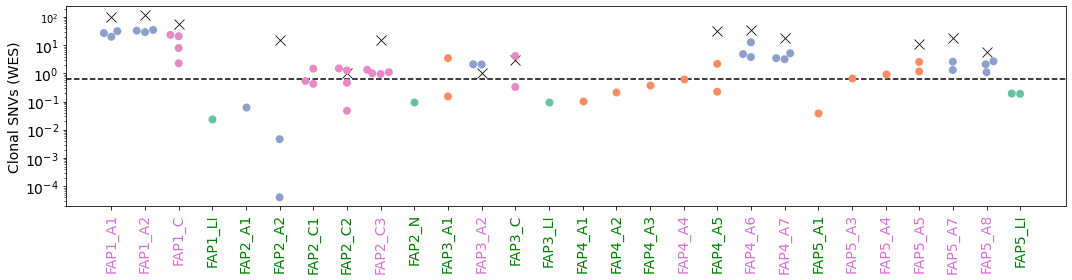

In [17]:
# EXTENDED DATA FIGURE 8a

to_plot = PKU_clonal[~np.isin(PKU_clonal["patient"], to_exclude)]

to_count = PKU_clonal[~np.isin(PKU_clonal["patient"], to_exclude)]
counted = to_count.groupby("lesion").min()
counted["is_poly"] = counted["exp_clonal"] < WES_cutoff

fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.swarmplot(x=to_plot["lesion"], y=to_plot["exp_clonal"], hue=to_plot["stage"], hue_order=["Mucosa", "Benign", "Dysplasia", "AdCa"], palette="Set2", legend=None, ax=ax, size=8)
sns.scatterplot(x=multiregion_lesions.index, y=shared_counts_MRS, marker="x", s=100, color="k")
ax.axhline(y=WES_cutoff, color="k", linestyle="dashed")
plt.xticks(rotation=90, fontsize=14)

for xtick in ax.get_xticklabels():
    if counted.loc[xtick._text]["is_poly"]:
        xtick.set_color(poly_color)
    else:
        xtick.set_color(mono_color)

plt.yticks(fontsize=14)
plt.ylabel("Clonal SNVs (WES)", fontsize=14)
plt.yscale("log")
plt.xlabel("")
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8a_FAP_Li_clonalmuts.pdf")
plt.show()

In [18]:
multiregion_lesions = pd.value_counts(BCI_clonal["patient"])
multiregion_lesions = multiregion_lesions[multiregion_lesions > 1]
#multiregion_lesions = multiregion_lesions[~np.isin([x.split("_")[0] for x in multiregion_lesions.index], to_exclude)]
shared_counts_MRS = []
for lesion in multiregion_lesions.index:
    only_lesion = BCI_maf[BCI_maf["Patient"]==lesion]
    shared_counts_MRS.append(number_shared_MRS(only_lesion))
    
BCI_clonal.sort_values("patient", inplace=True)

to_count = BCI_clonal

counted = to_count.groupby("patient").min()
counted["is_poly"] = counted["exp_clonal"] < WES_cutoff

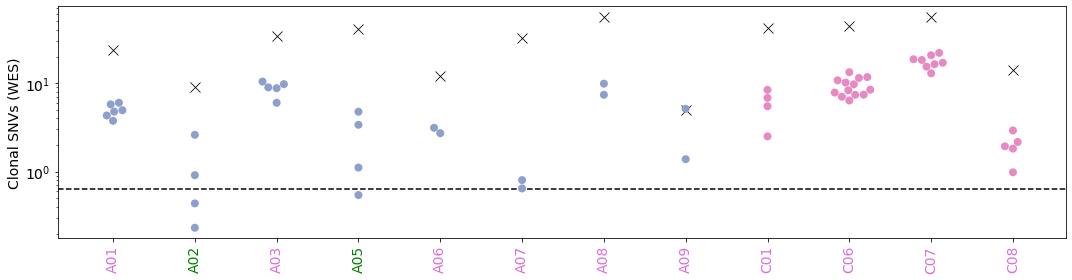

In [19]:
# EXTENDED DATA FIGURE 8b

WGS_cutoff = 27 + 36
WES_cutoff = WGS_cutoff * 0.01

fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.swarmplot(x=BCI_clonal["patient"], y=BCI_clonal["exp_clonal"], hue=BCI_clonal["stage"], hue_order=["none", "alsonone", "Adenoma", "Carcinoma"], palette="Set2", legend=None, ax=ax, size=8)
sns.scatterplot(x=multiregion_lesions.index, y=shared_counts_MRS, marker="x", s=100, color="k")
ax.axhline(y=WES_cutoff, color="k", linestyle="dashed")
plt.xticks(rotation=90, fontsize=14)

for xtick in ax.get_xticklabels():
    if counted.loc[xtick._text]["is_poly"]:
        xtick.set_color(poly_color)
    else:
        xtick.set_color(mono_color)

plt.yticks(fontsize=14)
plt.ylabel("Clonal SNVs (WES)", fontsize=14)
plt.yscale("log")
plt.xlabel("")
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8b_sporadic_Cross_clonalmuts.pdf")
plt.show()

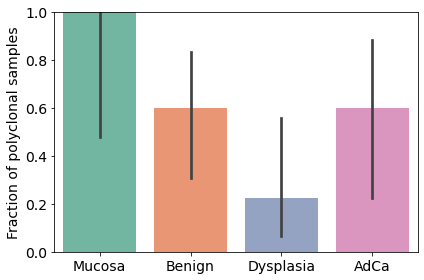

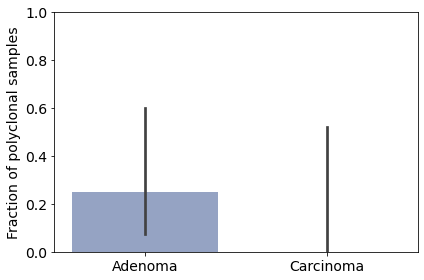

In [22]:
# EXTENDED DATA FIGURE 8c-d

def compute_binomial_bayes_CI(successes, failures, width=0.95):
    upper_quantile = 1 - (1-width)/2
    lower_quantile = (1-width)/2
    lower, upper = stats.beta.ppf([lower_quantile, upper_quantile], 1+successes, 1+failures)
    return lower, upper

def compute_errorbars(binom_data):
    return compute_binomial_bayes_CI(np.sum(binom_data), np.sum(~binom_data))

to_count = PKU_clonal[~np.isin(PKU_clonal["patient"], to_exclude)]
counted = to_count.groupby("lesion").min()
counted["is_poly"] = counted["exp_clonal"] < WES_cutoff

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
#sns.barplot(x=frac_poly.index, y=frac_poly, order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", errorbar=compute_errorbars)
sns.barplot(x=counted["stage"], y=counted["is_poly"], order=["Mucosa", "Benign", "Dysplasia", "AdCa"], palette="Set2", errorbar=compute_errorbars)
plt.ylabel("Fraction of polyclonal samples", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8c_FAP_Li_polyclonal.pdf")
plt.show()

to_count = BCI_clonal
counted = to_count.groupby("patient").min()
counted["is_poly"] = counted["exp_clonal"] < WES_cutoff

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
#sns.barplot(x=frac_poly.index, y=frac_poly, order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", errorbar=compute_errorbars)
sns.barplot(x=counted["stage"], y=counted["is_poly"], hue_order=["Adenoma", "Carcinoma"], palette=set2_colors[2:], errorbar=compute_errorbars)
plt.ylabel("Fraction of polyclonal samples", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"ED8d_sporadic_Cross_polyclonal.pdf")
plt.show()